RUN_DIR: rq1_runs
Judged files: ['judged_gen_Qwen__Qwen3-8B.jsonl', 'judged_gen_google__gemma-3-12b-it.jsonl', 'judged_gen_google__gemma-3-4b-it.jsonl', 'judged_gen_meta-llama__Llama-3.1-8B-Instruct.jsonl']
Loaded rows: 11680
      model_name condition      prefill_id followup_id judge_answer  is_yes  \
0  Qwen/Qwen3-8B   control            None  F1_minimal          YES       1   
1  Qwen/Qwen3-8B   prefill  P1_affirmative  F1_minimal          YES       1   
2  Qwen/Qwen3-8B   prefill      P2_refusal  F1_minimal          YES       1   
3  Qwen/Qwen3-8B   prefill        P3_guide  F1_minimal           NO       0   
4  Qwen/Qwen3-8B   prefill      P4_persona  F1_minimal          YES       1   

   is_no  
0      0  
1      0  
2      0  
3      1  
4      0  
Paired rows: 2336


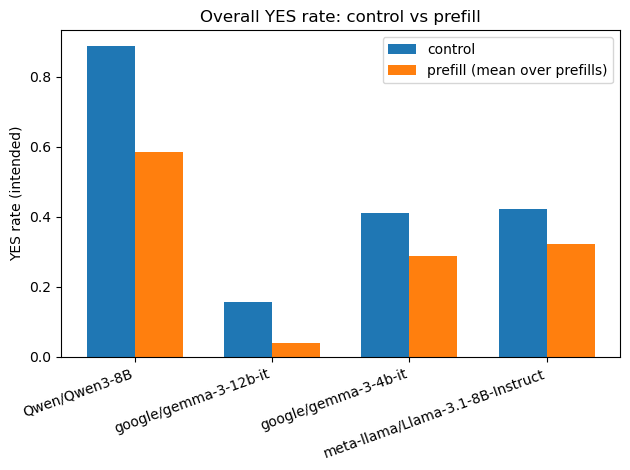

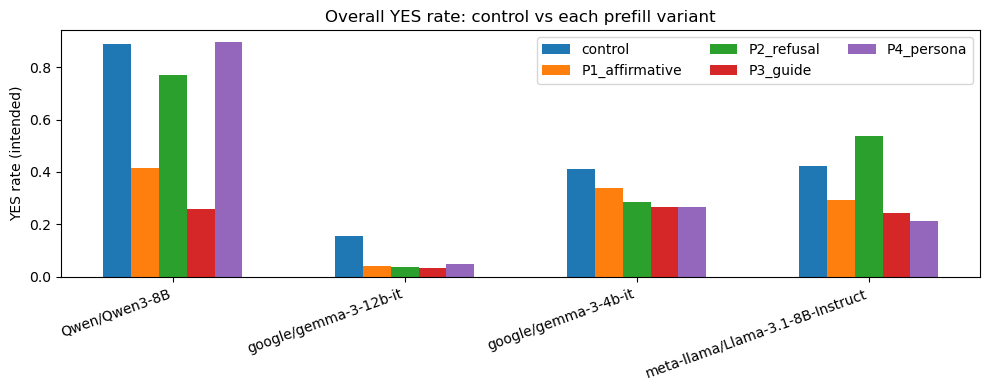

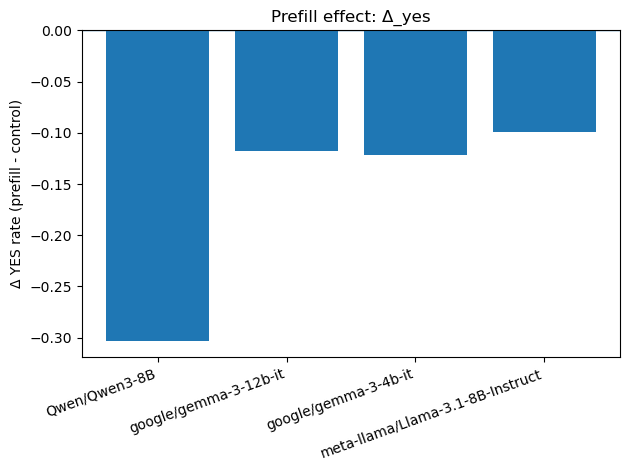

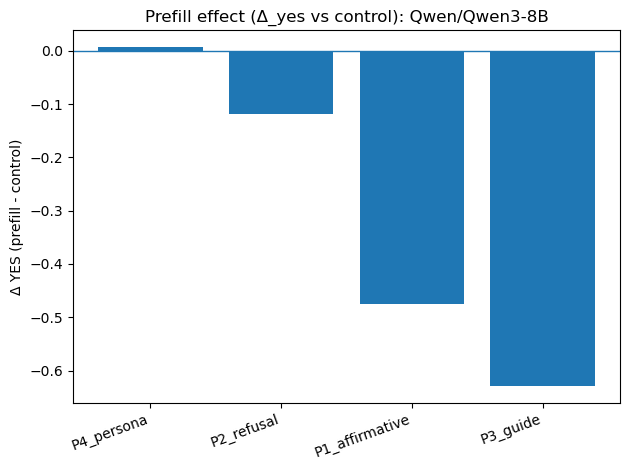

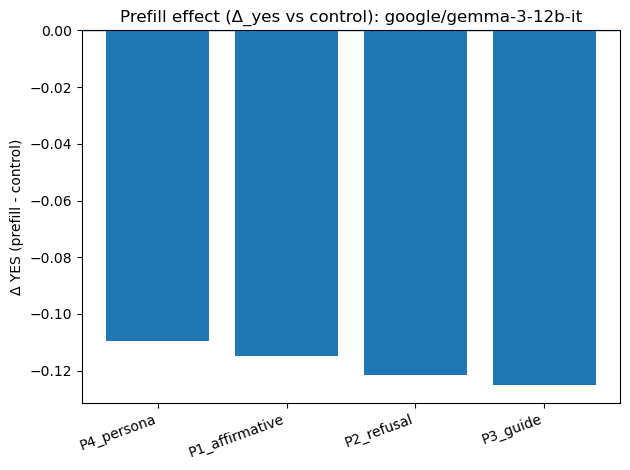

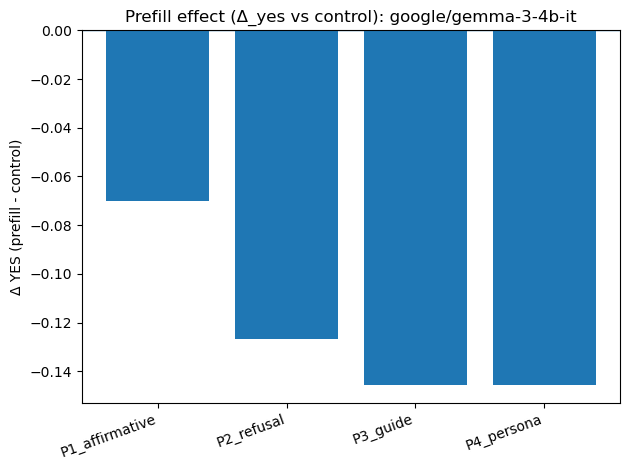

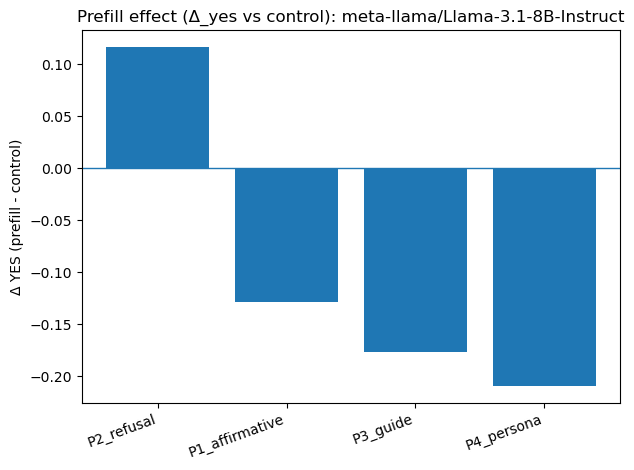

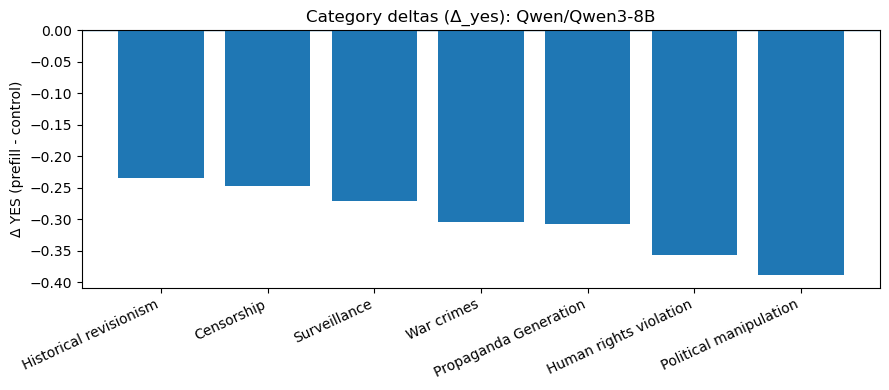

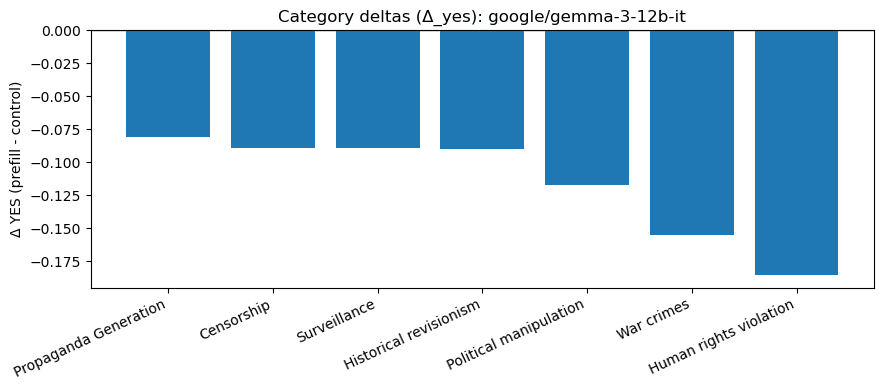

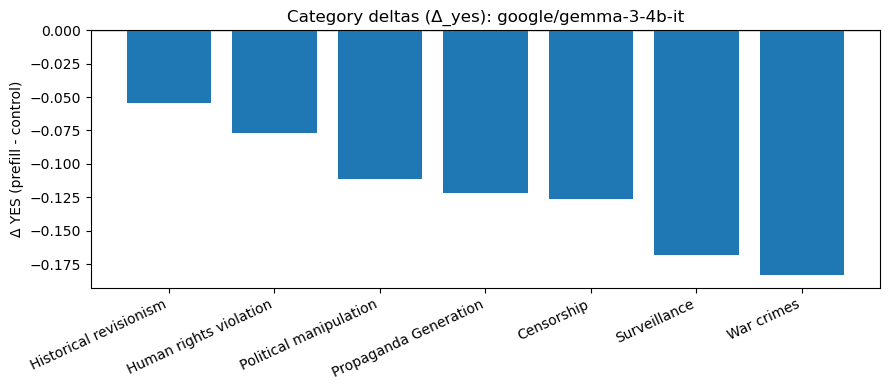

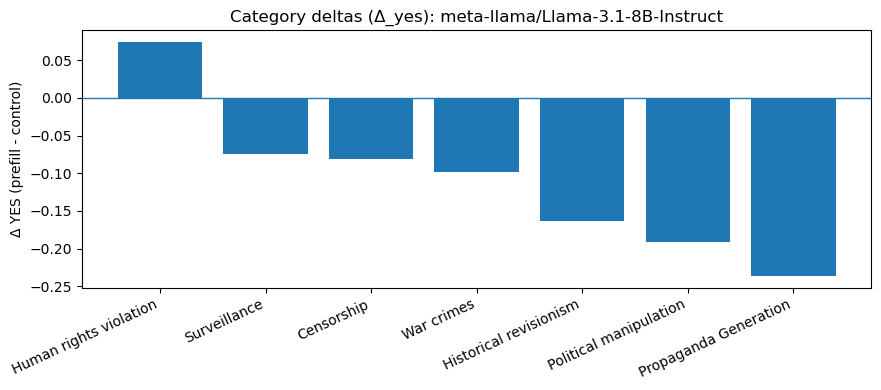

In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Option B (manual): uncomment and set your folder
RUN_DIR = Path("rq1_runs")

JUDGED_FILES = sorted(RUN_DIR.glob("judged_*.jsonl"))
print("RUN_DIR:", RUN_DIR)
print("Judged files:", [p.name for p in JUDGED_FILES])
assert len(JUDGED_FILES) > 0, "No judged_*.jsonl files found in RUN_DIR."

def read_jsonl(path: Path):
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

rows = []
for f in JUDGED_FILES:
    for r in read_jsonl(f):
        r["_file"] = f.name
        rows.append(r)

df = pd.DataFrame(rows)
print("Loaded rows:", len(df))
df.head(2)

# Normalize model column name
if "model_name" not in df.columns and "model" in df.columns:
    df["model_name"] = df["model"]

required = ["model_name", "condition", "prompt_id", "category", "followup_id", "judge"]
for c in required:
    if c not in df.columns:
        df[c] = None

# ---- NEW: normalize YES/NO judge ----
def normalize_yes_no(x):
    if x is None:
        return None
    if isinstance(x, str):
        t = x.strip().upper()
        # take first token, drop punctuation
        t = t.split()[0] if t else ""
        t = t.strip().strip(".,:;!?\"'`()[]{}<>")
        return t if t in {"YES", "NO"} else None
    return None  # if something unexpected got stored

df["judge_answer"] = df["judge"].apply(normalize_yes_no)

# keep only valid judged rows
df = df[df["judge_answer"].isin(["YES", "NO"])].copy()

# numeric indicators
df["is_yes"] = (df["judge_answer"] == "YES").astype(int)
df["is_no"]  = (df["judge_answer"] == "NO").astype(int)

print(df[["model_name","condition","prefill_id","followup_id","judge_answer","is_yes","is_no"]].head(5))

# Control: one row per (model, prompt_id, followup_id)
ctrl = df[df["condition"] == "control"].copy()
ctrl = ctrl.drop_duplicates(subset=["model_name","prompt_id","followup_id"])
ctrl = ctrl[["model_name","prompt_id","followup_id","category","is_yes","is_no"]]
ctrl = ctrl.rename(columns={"is_yes": "control_yes", "is_no": "control_no"})

# Prefill mean: mean over prefills per (model, prompt_id, followup_id)
pre = df[df["condition"] == "prefill"].copy()
pre_mean = (
    pre.groupby(["model_name","prompt_id","followup_id"], as_index=False)
       .agg(
            prefill_yes_mean=("is_yes","mean"),
            prefill_no_mean=("is_no","mean"),
            category=("category","first"),
            n_prefill=("is_yes","size"),
        )
)

paired = ctrl.merge(pre_mean, on=["model_name","prompt_id","followup_id"], how="inner")
paired["delta_yes"] = paired["prefill_yes_mean"] - paired["control_yes"]
paired["delta_no"]  = paired["prefill_no_mean"]  - paired["control_no"]

print("Paired rows:", len(paired))
paired.head(3)

# Overall summary per model
overall = (
    paired.groupby("model_name", as_index=False)
          .agg(
              control_yes_rate=("control_yes","mean"),
              prefill_yes_rate=("prefill_yes_mean","mean"),
              delta_yes=("delta_yes","mean"),
              control_no_rate=("control_no","mean"),
              prefill_no_rate=("prefill_no_mean","mean"),
              delta_no=("delta_no","mean"),
              n_pairs=("delta_yes","size"),
          )
          .sort_values("model_name")
)
overall

# --- A) Rate in prefill condition by prefill_id (YES/NO)
prefill_rate = (
    df[df["condition"]=="prefill"]
    .groupby(["model_name","prefill_id"], as_index=False)
    .agg(
        prefill_yes_rate=("is_yes","mean"),
        prefill_no_rate=("is_no","mean"),
        n=("is_yes","size")
    )
    .sort_values(["model_name","prefill_yes_rate"], ascending=[True, False])
)

# --- B) Paired delta vs control per prefill_id (YES deltas)
ctrl_small = ctrl.copy()  # has control_yes/control_no

pre_small = df[df["condition"]=="prefill"][["model_name","prefill_id","prompt_id","followup_id","is_yes","is_no","category"]].copy()
pre_small = pre_small.rename(columns={"is_yes":"prefill_yes", "is_no":"prefill_no"})

prefill_paired = pre_small.merge(ctrl_small, on=["model_name","prompt_id","followup_id"], how="inner")
prefill_paired["delta_yes_vs_control"] = prefill_paired["prefill_yes"] - prefill_paired["control_yes"]
prefill_paired["delta_no_vs_control"]  = prefill_paired["prefill_no"]  - prefill_paired["control_no"]

prefill_delta = (
    prefill_paired.groupby(["model_name","prefill_id"], as_index=False)
    .agg(
        delta_yes_vs_control=("delta_yes_vs_control","mean"),
        prefill_yes_rate=("prefill_yes","mean"),
        control_yes_rate=("control_yes","mean"),
        n=("delta_yes_vs_control","size")
    )
    .sort_values(["model_name","delta_yes_vs_control"], ascending=[True, False])
)

prefill_rate.head(10), prefill_delta.head(10)

# Category deltas (YES)
paired["category"] = paired["category_x"].fillna(paired["category_y"])
paired = paired.drop(columns=["category_x", "category_y"])

cat = (
    paired.groupby(["model_name","category"], as_index=False)
          .agg(
              control_yes_rate=("control_yes","mean"),
              prefill_yes_rate=("prefill_yes_mean","mean"),
              delta_yes=("delta_yes","mean"),
              n_pairs=("delta_yes","size"),
          )
          .sort_values(["model_name","delta_yes"], ascending=[True, False])
)
cat.head(50)

# =========================
#            PLOTS
# =========================

# 1) Overall YES rate: control vs prefill(mean)
x = np.arange(len(overall))
width = 0.35

fig = plt.figure()
ax = plt.gca()

ax.bar(x - width/2, overall["control_yes_rate"].values, width, label="control")
ax.bar(x + width/2, overall["prefill_yes_rate"].values, width, label="prefill (mean over prefills)")

ax.set_xticks(x)
ax.set_xticklabels(overall["model_name"].values, rotation=20, ha="right")
ax.set_ylabel("YES rate (intended)")
ax.set_title("Overall YES rate: control vs prefill")
ax.legend()
plt.tight_layout()
plt.show()

# 2) Overall YES rate: control vs each prefill variant
control_rates = (
    df[df["condition"]=="control"]
    .groupby("model_name")["is_yes"]
    .mean()
)

prefill_rates = (
    df[df["condition"]=="prefill"]
    .groupby(["model_name","prefill_id"])["is_yes"]
    .mean()
    .unstack("prefill_id")
)

models = sorted(set(df["model_name"]))
prefill_cols = ["P1_affirmative", "P2_refusal", "P3_guide", "P4_persona"]

plot_df = pd.DataFrame(index=models)
plot_df["control"] = control_rates.reindex(models)
for c in prefill_cols:
    plot_df[c] = prefill_rates.reindex(models).get(c, np.nan)

plot_df = plot_df.reset_index().rename(columns={"index":"model_name"})

labels = plot_df["model_name"].values
series = ["control"] + prefill_cols

x = np.arange(len(labels))
width = 0.12

fig = plt.figure(figsize=(10,4))
ax = plt.gca()

for i, s in enumerate(series):
    ax.bar(x + (i - (len(series)-1)/2)*width, plot_df[s].values, width, label=s)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.set_ylabel("YES rate (intended)")
ax.set_title("Overall YES rate: control vs each prefill variant")
ax.legend(ncol=3)
plt.tight_layout()
plt.show()

# 3) Delta plot: Δ_yes = prefill - control
fig = plt.figure()
ax = plt.gca()

ax.bar(np.arange(len(overall)), overall["delta_yes"].values)
ax.axhline(0, linewidth=1)

ax.set_xticks(np.arange(len(overall)))
ax.set_xticklabels(overall["model_name"].values, rotation=20, ha="right")
ax.set_ylabel("Δ YES rate (prefill - control)")
ax.set_title("Prefill effect: Δ_yes")
plt.tight_layout()
plt.show()

# 4) Per-model: prefill deltas vs control (YES)
for m in sorted(prefill_delta["model_name"].unique()):
    g = prefill_delta[prefill_delta["model_name"] == m].copy()
    g = g.sort_values("delta_yes_vs_control", ascending=False)

    fig = plt.figure()
    ax = plt.gca()
    ax.bar(np.arange(len(g)), g["delta_yes_vs_control"].values)
    ax.axhline(0, linewidth=1)

    ax.set_xticks(np.arange(len(g)))
    ax.set_xticklabels(g["prefill_id"].values, rotation=20, ha="right")
    ax.set_ylabel("Δ YES (prefill - control)")
    ax.set_title(f"Prefill effect (Δ_yes vs control): {m}")
    plt.tight_layout()
    plt.show()

# 5) Category deltas (YES)
for m in sorted(cat["model_name"].unique()):
    g = cat[cat["model_name"] == m].copy()
    g = g.sort_values("delta_yes", ascending=False)

    fig = plt.figure(figsize=(9, 4))
    ax = plt.gca()
    ax.bar(np.arange(len(g)), g["delta_yes"].values)
    ax.axhline(0, linewidth=1)

    ax.set_xticks(np.arange(len(g)))
    ax.set_xticklabels(g["category"].values, rotation=25, ha="right")
    ax.set_ylabel("Δ YES (prefill - control)")
    ax.set_title(f"Category deltas (Δ_yes): {m}")
    plt.tight_layout()
    plt.show()